In [1]:
from google.colab import files
uploaded = files.upload()
print(uploaded.keys())


Saving Spotify_data.csv to Spotify_data.csv
dict_keys(['Spotify_data.csv'])


In [2]:
from google.colab import files
uploaded = files.upload()
print(uploaded.keys())


Saving user_profiles_for_ads.csv to user_profiles_for_ads.csv
dict_keys(['user_profiles_for_ads.csv'])


MSE: 44.79
R² : 0.33
Enter a song name : Not like us
Enter a user ID    : 4
User Profile
Age 35-44 | Female | Rural
Interests : Gaming, DIY Crafts
Device Desktop Only | CTR 0.093
Online hrs (Week/W‑end) : 3.1 / 4.2

Song Prediction
Not Like Us – Kendrick Lamar
Album Not Like Us
Release Date 2024-05-04
Link  https://open.spotify.com/track/6AI3ezQ4o3HUoP6Dhudph3

Popularity
Actual 96 | Predicted 87.55
Streams 100M–500M | Downloads 1M–10M | Chart Top 50



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


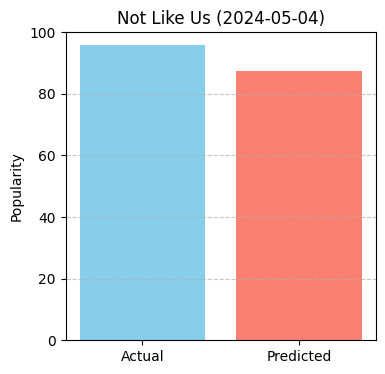

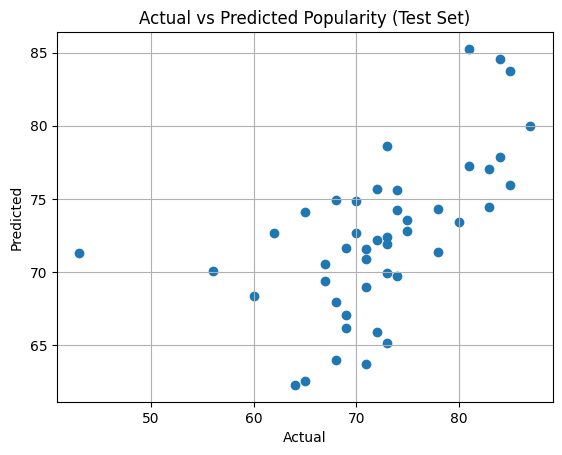

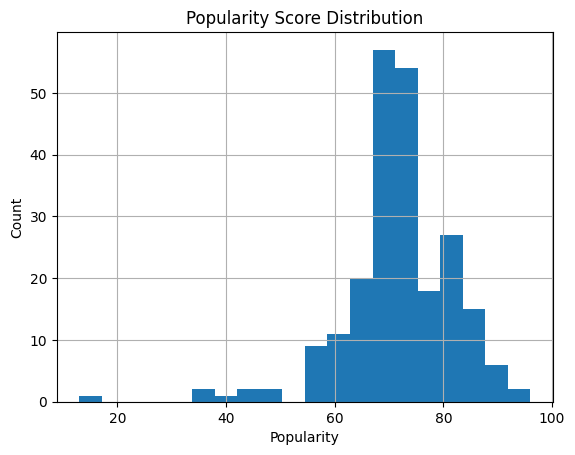

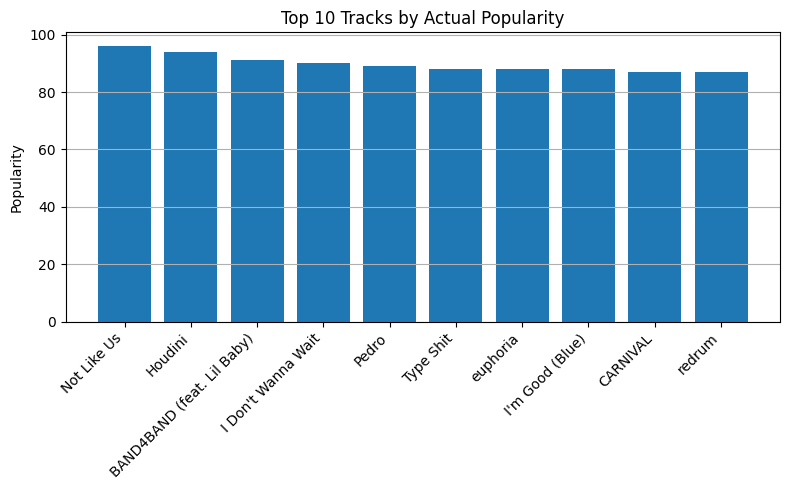

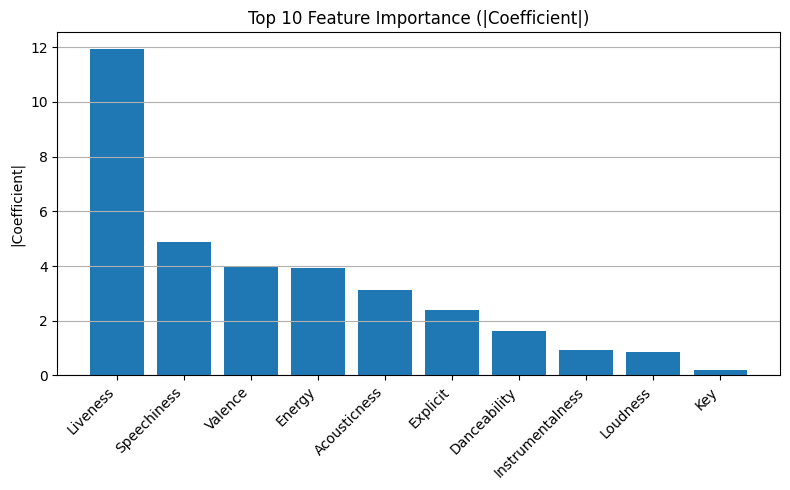

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd, numpy as np, difflib, re, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files

spotify_df = pd.read_csv('Spotify_data.csv').dropna()
user_df    = pd.read_csv('user_profiles_for_ads.csv').dropna()

X = spotify_df.drop(columns=['Popularity','Track Name','Artists','Album Name',
                             'Album ID','Track ID','Release Date','External URLs'],
                    errors='ignore')
y = spotify_df['Popularity']
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=42)
model = LinearRegression().fit(Xtr,ytr)

print("MSE:", round(mean_squared_error(yte, model.predict(Xte)), 2))
print("R² :", round(r2_score(yte, model.predict(Xte)), 2))

song_input = input("Enter a song name : ").strip()
user_input = input("Enter a user ID    : ").strip()

match = difflib.get_close_matches(song_input, spotify_df['Track Name'].unique(), n=1, cutoff=0.6)
if not match:
    print("Song not found.")
    quit()

song   = spotify_df[spotify_df['Track Name'] == match[0]].iloc[0]
release= song['Release Date']
xf     = song.drop(labels=['Popularity','Track Name','Artists','Album Name',
                           'Album ID','Track ID','Release Date','External URLs'],
                   errors='ignore').values.reshape(1,-1)
pred   = model.predict(xf)[0]
actual = song['Popularity']

def bucketscore(p):
    if p >= 90: return "500M+", "10M+", "Top 10"
    if p >= 75: return "100M–500M", "1M–10M", "Top 50"
    if p >= 50: return "10M–100M", "100K–1M", "Top 100"
    return "<10M", "<100K", "Below 100"
streams, downloads, chart = bucketscore(pred)

user_row = user_df[user_df['User ID'].astype(str) == user_input]
if user_row.empty:
    profile = "User not found\n"
else:
    u = user_row.iloc[0]
    profile = (f"User Profile\n"
               f"Age {u['Age']} | {u['Gender']} | {u['Location']}\n"
               f"Interests : {u['Top Interests']}\n"
               f"Device {u['Device Usage']} | CTR {u['Click-Through Rates (CTR)']}\n"
               f"Online hrs (Week/W‑end) : {u['Time Spent Online (hrs/weekday)']} / "
               f"{u['Time Spent Online (hrs/weekend)']}\n")

text = (profile +
        f"\nSong Prediction\n{song['Track Name']} – {song['Artists']}\n"
        f"Album {song['Album Name']}\nRelease Date {release}\n"
        f"Link  {song['External URLs']}\n\n"
        f"Popularity\nActual {actual} | Predicted {pred:.2f}\n"
        f"Streams {streams} | Downloads {downloads} | Chart {chart}\n")

print(text)

plt.figure(figsize=(4,4))
plt.bar(['Actual','Predicted'], [actual, pred], color=['skyblue','salmon'])
plt.title(f"{song['Track Name']} ({release})")
plt.ylabel("Popularity")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=.7)
plt.show()

plt.figure()
plt.scatter(yte, model.predict(Xte))
plt.title("Actual vs Predicted Popularity (Test Set)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(y, bins=20)
plt.title("Popularity Score Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.grid(True)
plt.show()

top10 = spotify_df.sort_values('Popularity', ascending=False).head(10)
plt.figure(figsize=(8,5))
plt.bar(top10['Track Name'], top10['Popularity'])
plt.title("Top 10 Tracks by Actual Popularity")
plt.ylabel("Popularity")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

coef = pd.Series(model.coef_, index=X.columns).abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
plt.bar(coef.index, coef.values)
plt.title("Top 10 Feature Importance (|Coefficient|)")
plt.ylabel("|Coefficient|")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

with open("music_prediction_result.txt", "w", encoding="utf-8") as f:
    f.write(text)
files.download("music_prediction_result.txt")
